In [1]:
%load_ext watermark


In [2]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import seaborn as sns
from teeplot import teeplot as tp
from tqdm import tqdm

from pylib._seed_global_rngs import seed_global_rngs


Covasim 3.1.6 (2024-01-28) — © 2020-2024 by IDM


In [3]:
%watermark -diwmuv -iv


Last updated: 2025-05-03T04:12:45.980702+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1027-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

numpy  : 2.1.2
pandas : 2.2.3
teeplot: 1.4.2
seaborn: 0.13.2

Watermark: 2.4.3



In [4]:
teeplot_subdir = "2025-04-30-profile-mut-screen"
teeplot_subdir


'2025-04-30-profile-mut-screen'

In [5]:
seed_global_rngs(1)


## Get Data


In [6]:
df = pd.read_parquet("https://osf.io/ag5w7/download")


In [7]:
df["replicate_uuid"].nunique()


15

In [8]:
df["is_focal_mutation"] = df["mut_char_pos"] == 0


In [9]:
stats = (
    "binom_p",
    "binom_stat",
    "trinom_p",
    "trinom_stat",
    "trinom_p_fill0",
    "trinom_stat_fill0",
    "mw_p",
    "cliffs_delta",
    "mw_p_dropna",
    "cliffs_delta_dropna",
)


In [10]:
records = []
groups = df[
    (df["trt_hsurf_bits"] == 0)
    & (df["trt_n_downsample"] == df["trt_n_downsample"].max())
    & (df["tb_stat"].str.contains("ratio"))
].groupby(
    ["trt_name", "replicate_uuid", "screen_uuid", "screen_name", "tb_stat"],
    observed=True,
)
for (trt_name, replicate_uuid, screen_uuid, screen_name, tb_stat), grp in tqdm(
    groups,
):
    grp_focal = grp[grp["is_focal_mutation"]]
    grp_nonfocal = grp[~grp["is_focal_mutation"]]

    record = {
        "trt_name": trt_name,
        "replicate_uuid": replicate_uuid,
        "screen_uuid": screen_uuid,
        "screen_name": screen_name,
        "tb_stat": tb_stat,
    }

    records.append(
        {
            **record,
            **{
                stat: (
                    np.nan if len(grp_focal) == 0 else grp_focal[stat].item()
                )
                for stat in stats
            },
            **{"mutation": "focal"},
        },
    )
    for __ in range(1_000):
        records.append(
            {
                **record,
                **{
                    stat: grp_nonfocal[stat].sample(1).item() for stat in stats
                },
                **{"mutation": "nonfocal"},
            },
        )


100%|██████████| 180/180 [02:43<00:00,  1.10it/s]


teeplots/col=tb-stat+hue=mutation+kind=box+row=screen-name+viz=catplot+x=trt-name+y=binom-p+ext=.pdf
teeplots/col=tb-stat+hue=mutation+kind=box+row=screen-name+viz=catplot+x=trt-name+y=binom-p+ext=.png


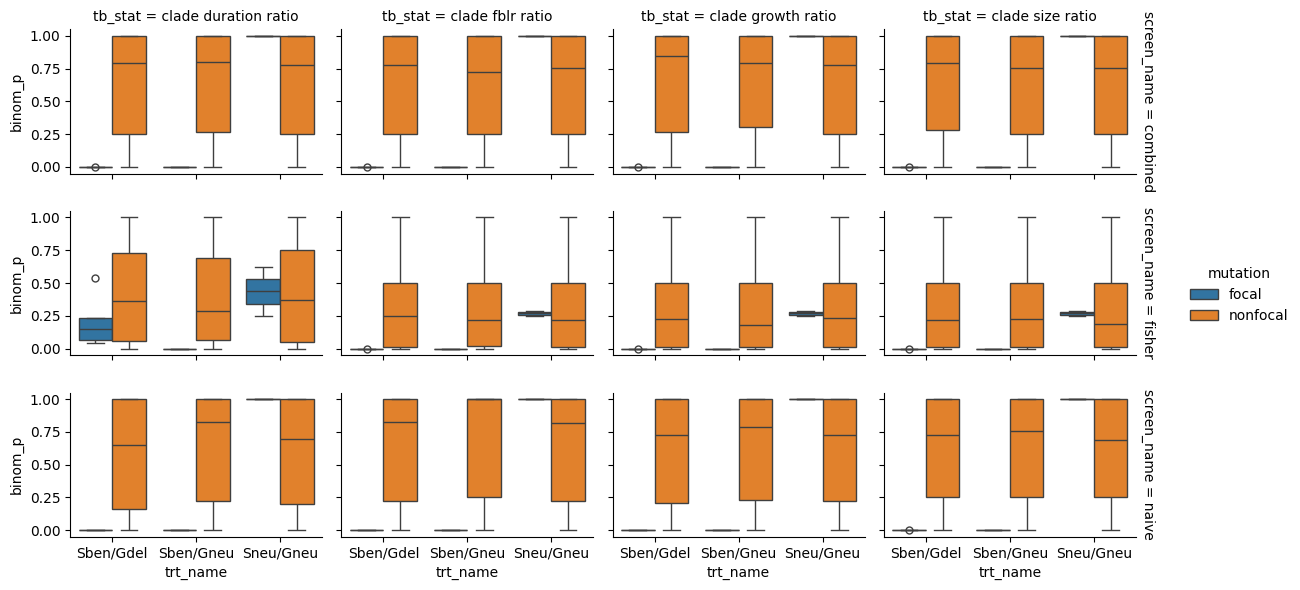

teeplots/col=tb-stat+hue=mutation+kind=box+row=screen-name+viz=catplot+x=trt-name+y=binom-stat+ext=.pdf
teeplots/col=tb-stat+hue=mutation+kind=box+row=screen-name+viz=catplot+x=trt-name+y=binom-stat+ext=.png


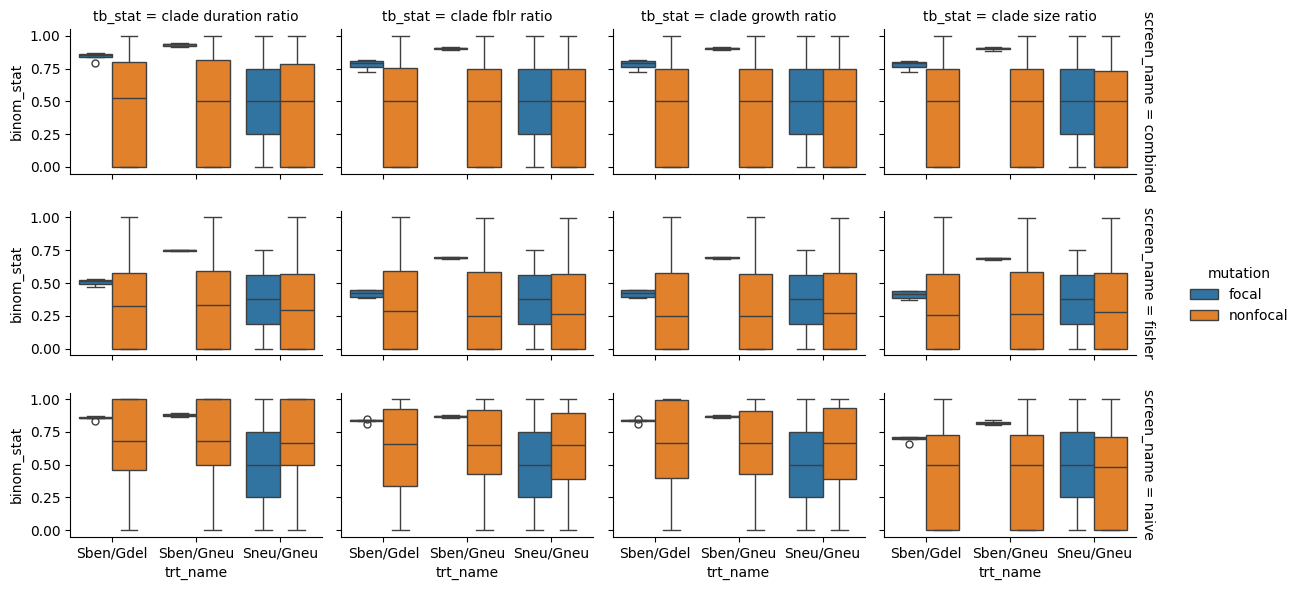

teeplots/col=tb-stat+hue=mutation+kind=box+row=screen-name+viz=catplot+x=trt-name+y=trinom-p+ext=.pdf
teeplots/col=tb-stat+hue=mutation+kind=box+row=screen-name+viz=catplot+x=trt-name+y=trinom-p+ext=.png


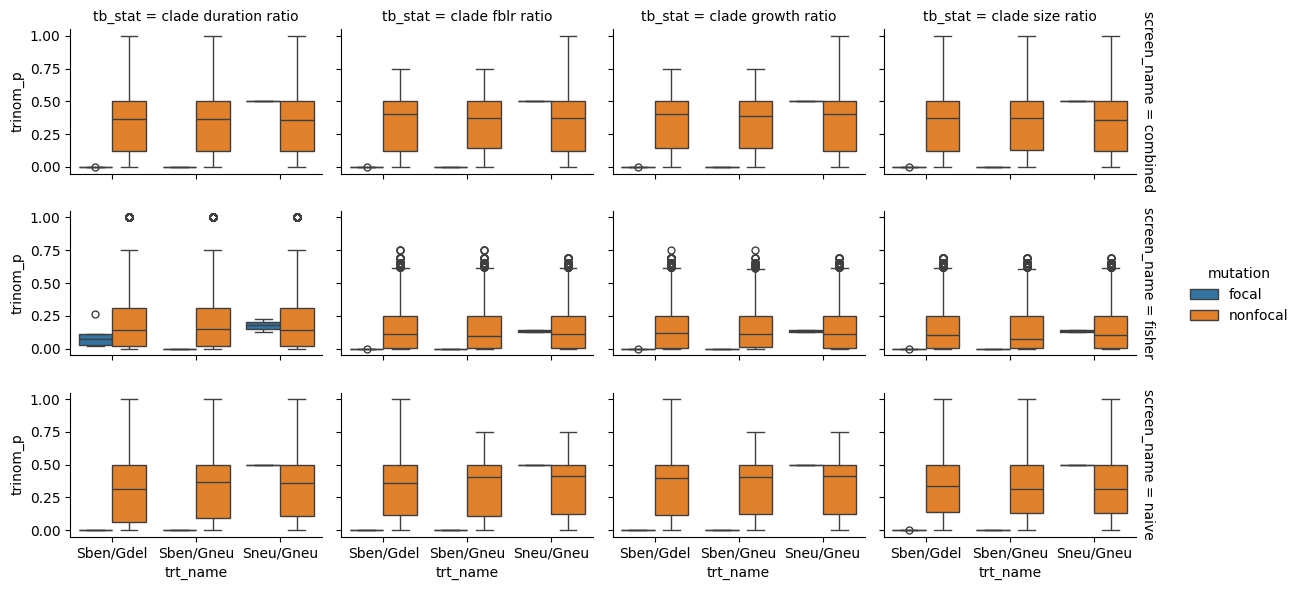

teeplots/col=tb-stat+hue=mutation+kind=box+row=screen-name+viz=catplot+x=trt-name+y=trinom-stat+ext=.pdf
teeplots/col=tb-stat+hue=mutation+kind=box+row=screen-name+viz=catplot+x=trt-name+y=trinom-stat+ext=.png


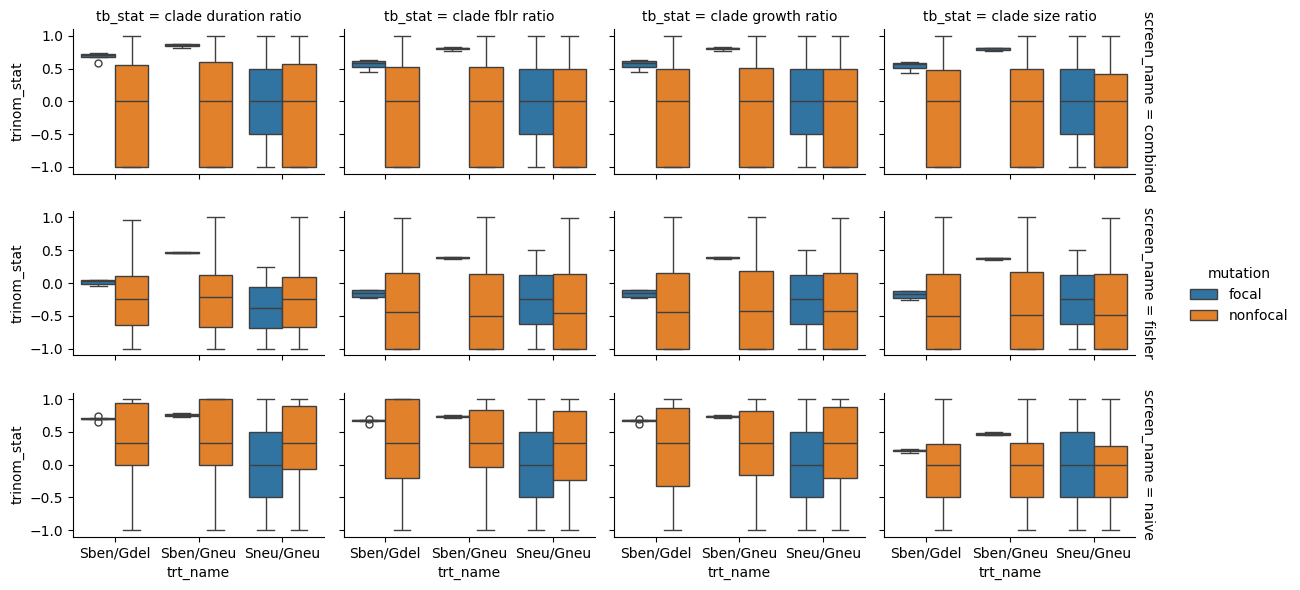

teeplots/col=tb-stat+hue=mutation+kind=box+row=screen-name+viz=catplot+x=trt-name+y=trinom-p-fill0+ext=.pdf
teeplots/col=tb-stat+hue=mutation+kind=box+row=screen-name+viz=catplot+x=trt-name+y=trinom-p-fill0+ext=.png


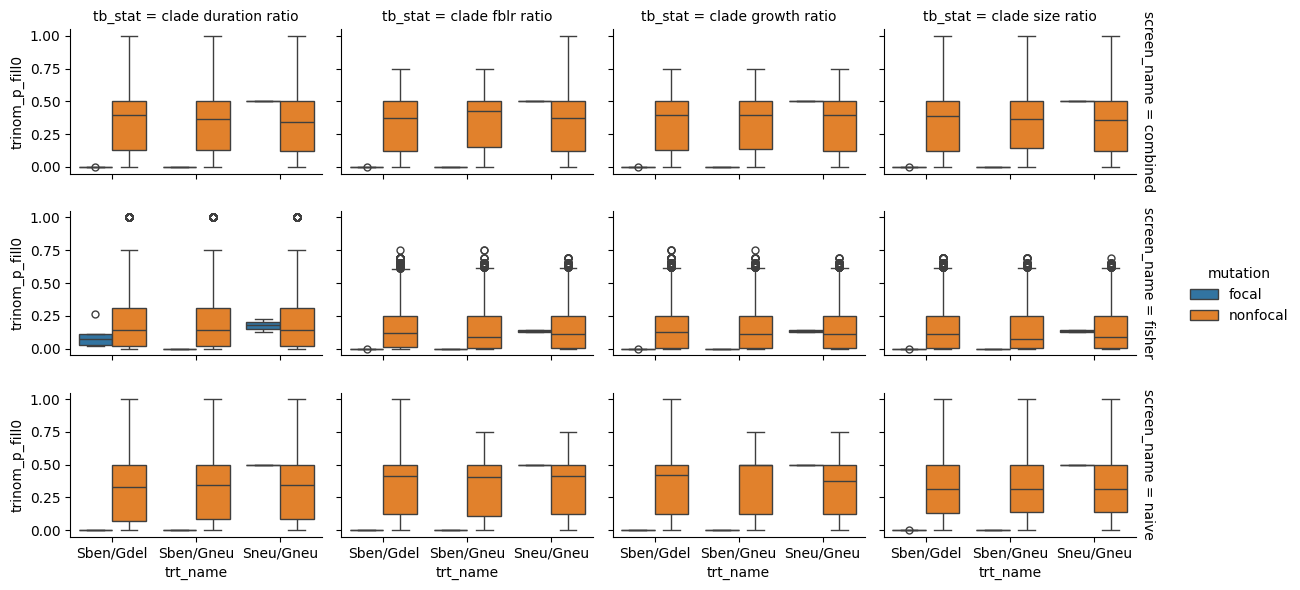

teeplots/col=tb-stat+hue=mutation+kind=box+row=screen-name+viz=catplot+x=trt-name+y=trinom-stat-fill0+ext=.pdf
teeplots/col=tb-stat+hue=mutation+kind=box+row=screen-name+viz=catplot+x=trt-name+y=trinom-stat-fill0+ext=.png


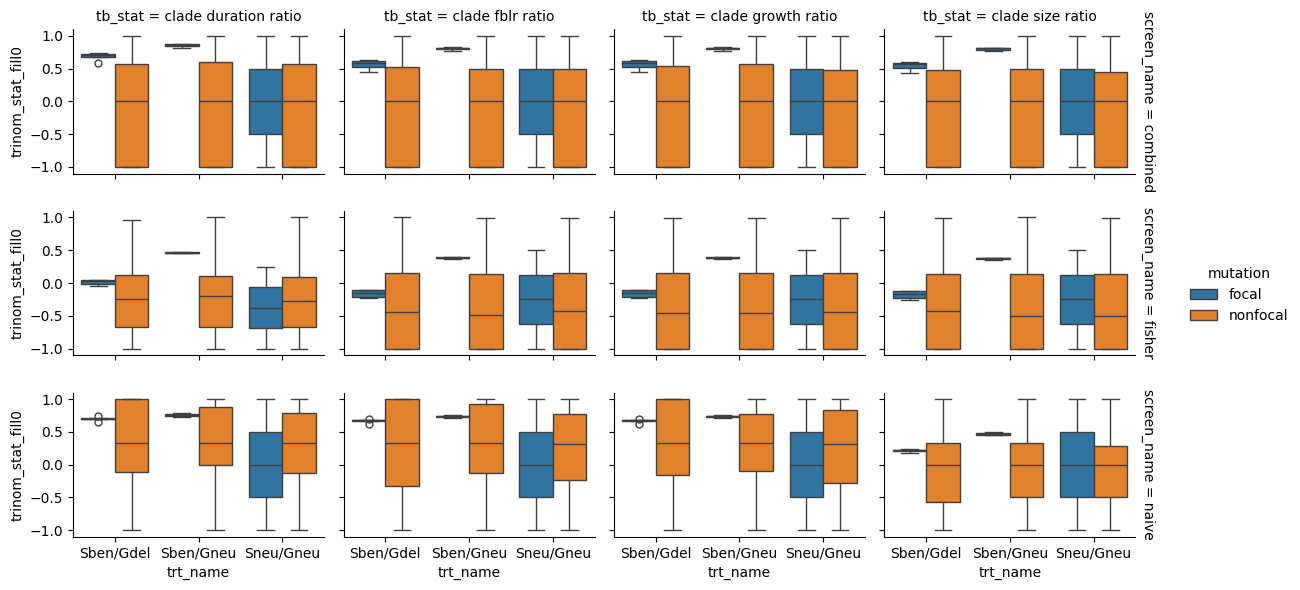

teeplots/col=tb-stat+hue=mutation+kind=box+row=screen-name+viz=catplot+x=trt-name+y=mw-p+ext=.pdf
teeplots/col=tb-stat+hue=mutation+kind=box+row=screen-name+viz=catplot+x=trt-name+y=mw-p+ext=.png


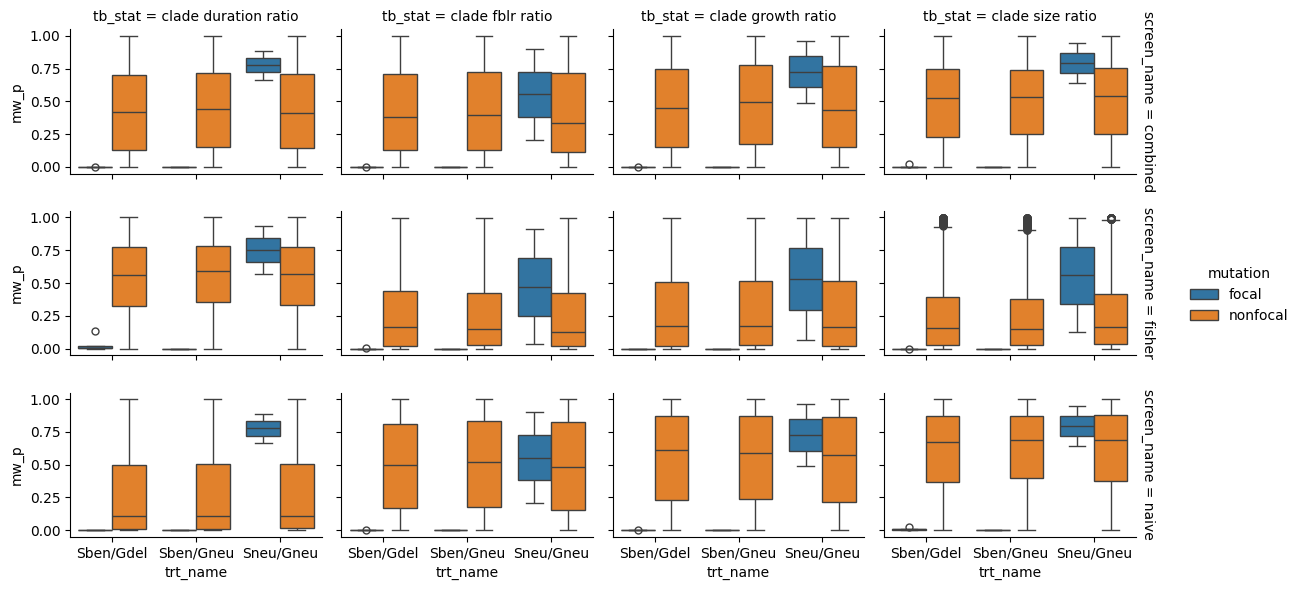

teeplots/col=tb-stat+hue=mutation+kind=box+row=screen-name+viz=catplot+x=trt-name+y=cliffs-delta+ext=.pdf
teeplots/col=tb-stat+hue=mutation+kind=box+row=screen-name+viz=catplot+x=trt-name+y=cliffs-delta+ext=.png


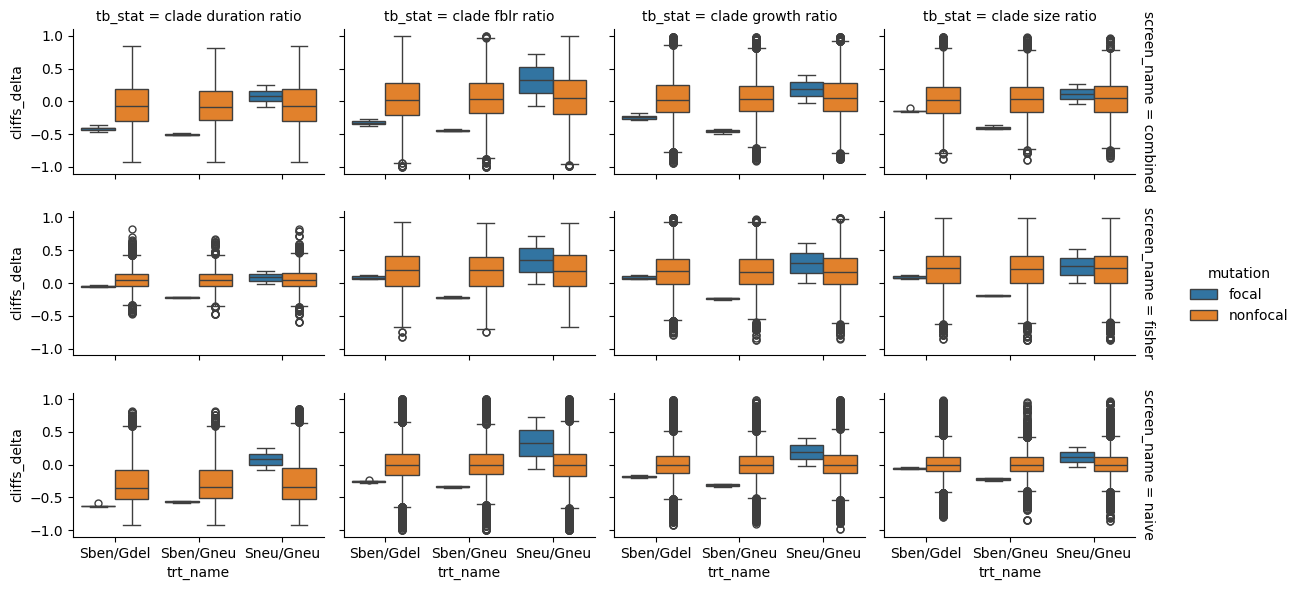

teeplots/col=tb-stat+hue=mutation+kind=box+row=screen-name+viz=catplot+x=trt-name+y=mw-p-dropna+ext=.pdf
teeplots/col=tb-stat+hue=mutation+kind=box+row=screen-name+viz=catplot+x=trt-name+y=mw-p-dropna+ext=.png


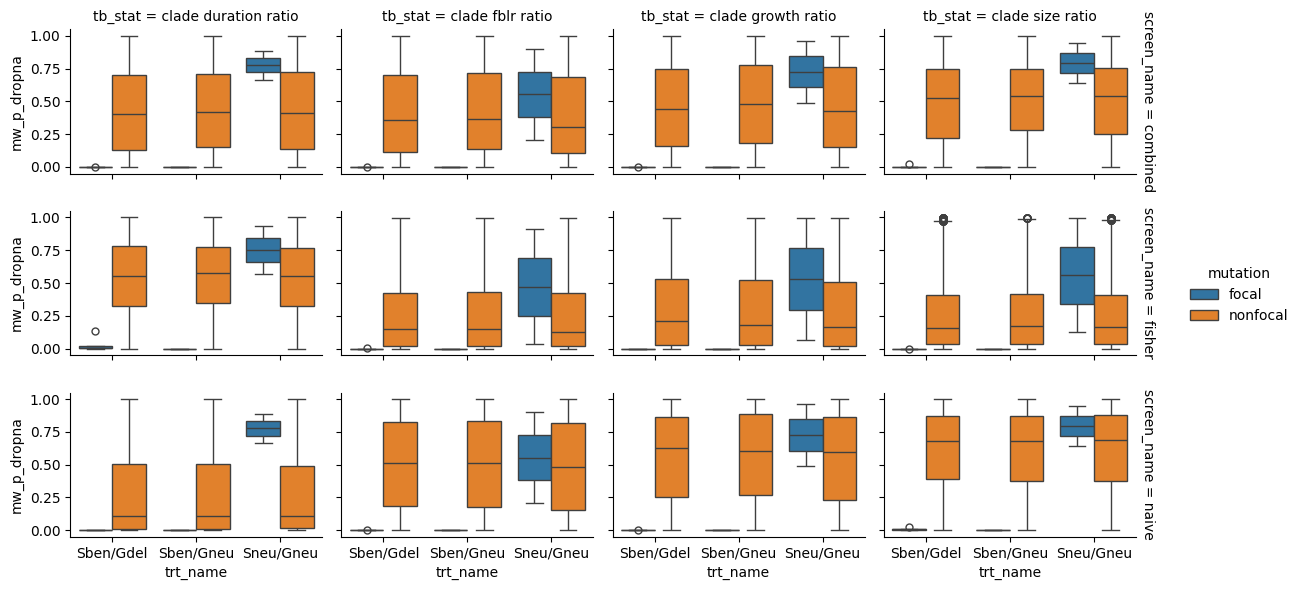

teeplots/col=tb-stat+hue=mutation+kind=box+row=screen-name+viz=catplot+x=trt-name+y=cliffs-delta-dropna+ext=.pdf
teeplots/col=tb-stat+hue=mutation+kind=box+row=screen-name+viz=catplot+x=trt-name+y=cliffs-delta-dropna+ext=.png


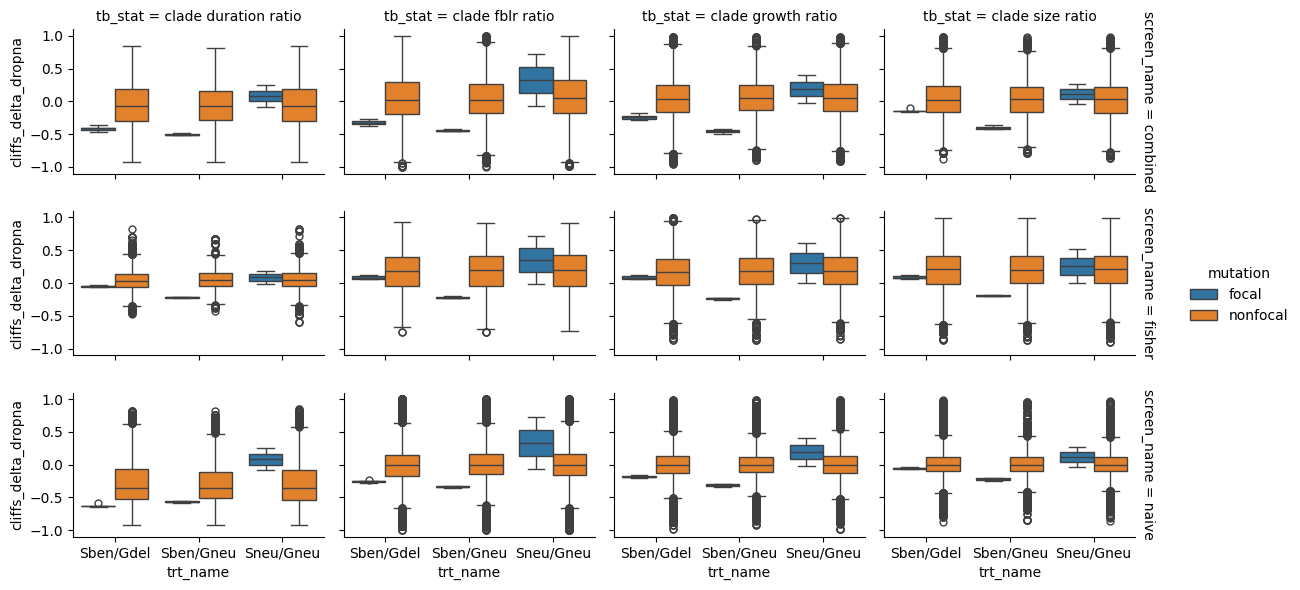

In [11]:
for stat in stats:
    display(HTML(f"<h3>{stat}</h3>"))
    with tp.teed(
        sns.catplot,
        data=pd.DataFrame(records),
        x="trt_name",
        y=stat,
        hue="mutation",
        row="screen_name",
        col="tb_stat",
        kind="box",
        height=2,
        aspect=1.5,
        margin_titles=True,
    ):
        pass


In [12]:
df.loc[
    (df["trt_name"] == "Sben/Gneu")
    & (df["mut_char_pos"] == 0)
    & (df["tb_stat"].str.endswith("ratio")),
    [
        "mut_nobs",
        "mut_freq",
        "binom_n",
        "binom_k",
        "binom_p",
        "mw_p_dropna",
        "tb_stat",
        "screened_N",
        "trt_name",
        "mut_char_pos",
        "screened_nanmean",
    ],
].sample(25)


,mut_nobs,mut_freq,binom_n,binom_k,binom_p,mw_p_dropna,tb_stat,screened_N,trt_name,mut_char_pos,screened_nanmean
98450,21453,0.035575,2034,1824,0.000000e+00,0.000000e+00,clade duration ratio,2057,Sben/Gneu,0,NaN
112375,11334,0.018826,4732,1958,1.556268e-32,0.000000e+00,clade fblr ratio,4739,Sben/Gneu,0,-0.001070
112381,11334,0.018826,4530,1851,6.929543e-35,0.000000e+00,clade size ratio,4739,Sben/Gneu,0,-0.408969
14115,20854,0.034385,903,820,0.000000e+00,0.000000e+00,clade fblr ratio,903,Sben/Gneu,0,0.006282
14116,20854,0.034385,3220,2200,0.000000e+00,0.000000e+00,clade fblr ratio,3221,Sben/Gneu,0,0.002570
42426,18404,0.030120,961,854,0.000000e+00,0.000000e+00,clade growth ratio,962,Sben/Gneu,0,0.014177
112373,11334,0.018826,5677,2398,1.231846e-31,0.000000e+00,clade duration ratio,6649,Sben/Gneu,0,NaN
42423,18404,0.030120,961,854,0.000000e+00,0.000000e+00,clade fblr ratio,962,Sben/Gneu,0,0.006588
28276,11059,0.018264,4564,1770,0.000000e+00,0.000000e+00,clade size ratio,4790,Sben/Gneu,0,-0.451830
112380,11334,0.018826,1407,478,1.026997e-33,0.000000e+00,clade size ratio,1538,Sben/Gneu,0,-0.861009
